**TITLE**:
Using serum cholesterol and age to diagnose the presence of heart disease in patients from Cleveland.

By: Melissa Kim

**INTRODUCTION**:

Heart disease, also known as cardiovascular disease affects the heart and blood vessels. One of the most common heart diseases is coronary artery disease, which comes from narrow or blocked coronary arteries. Risk factors increase the chance of developing this heart disease, including serum cholesterol levels and age. 

Serum cholesterol is a waxy substance found in the blood. With high cholesterol levels, fatty deposits develop in the blood vessels and affects the blood flow in the arteries, forming clots. Advancing age can also build up fatty deposits in the arteries over time, changing heart and blood vessels. Hence, increasing age and serum cholesterol levels could increase the risk of heart disease according to research. 

Therefore, my question is "Can age and serum cholesterol be used to accuratley predict the likelihood of heart disease in a new patient?". To answer my question, I will use the K-nearest neighbours classification algorithm to predict a diagnosis.

The data I will be using is the processed.cleveland.data from the Heart Disease database. This data was originally from UCI Heart Disease Dataset (Cleveland Clinic) and I will be using predictors age and serum cholesterol (mg/dl) out of the listed columns (age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, num) to predict whether a new patient has heart disease using classification. 

**METHOD AND RESULTS**:

Firstly, I will clean and wrangle the data after reading the processed data with `reac_csv`. Then, the preprocessed data will be split into training and test sets. The training set will be used to model the classifier. I also summarized the training set to make predictions and to see the relationship between the predictors. Lastly, a visualization of the training set will be made between my two predictors and class to see the distribution.  


Finding the best $k$ value: 

To provide a high-accuracy prediction, the best $k$ value will be used by performing cross-validation. 

1. I will create a recipe that scales the data (for each feature to contribute proportionally to the distance metric).
2. Using `vfold_cv`, I will perform the 5-fold cross-validation to increase my accuracy estimate (lower standard error).
3. I will then create my model using `nearest_neighbour` and tune the classifier.
4. Using workflow, (`tune_grid` will be used), along with adding the model and recipe.
5. Specify the $k$ value range using `gridvals`.
6. Finally, I will find the best $k$ value using a line plot (accuracy vs K-values plot).

For visualization, I will plot the age predictor on the x-axis, and serum cholesterol on the y-axis, colouring in the points for diagnosis (presence or absense of heart disease). The accuracy, precision and recall of my classifer will also be discussed. 

In [1]:
#importing packages
library(repr)
library(tidyverse)
library(tidymodels)
library(scales)
library(readr)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#loading data
cleveland_data <- read_csv("data/heart_disease/processed.cleveland.data", col_names = FALSE)
head(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1 X2 X3 X4  X5  X6 X7 X8  X9 X10 X11 X12 X13 X14
1 63 1  1  145 233 1  2  150 0  2.3 3   0.0 6.0 0  
2 67 1  4  160 286 0  2  108 1  1.5 2   3.0 3.0 2  
3 67 1  4  120 229 0  2  129 1  2.6 2   2.0 7.0 1  
4 37 1  3  130 250 0  0  187 0  3.5 3   0.0 3.0 0  
5 41 0  2  130 204 0  2  172 0  1.4 1   0.0 3.0 0  
6 56 1  2  120 236 0  0  178 0  0.8 1   0.0 3.0 0

_Figure 1_

The data does not come with column names, so I need to add the names using `rename`. I only need to select the columns I need for my analysis which are age, serum cholesterol and num. Since I am using classification, I must mutate the "num" column's data type into a categorical label.

In [3]:
set.seed(2)
selected_data <- cleveland_data |>
    rename(age = X1, cholesterol = X5, num = X14) |>
     select(num, cholesterol, age) |>
     mutate(num = as_factor(num)) 
head(selected_data)

num cholesterol age
1 0   233         63 
2 2   286         67 
3 1   229         67 
4 0   250         37 
5 0   204         41 
6 0   236         56

_Figure 2_

Based on the "num" column, where values 1 to 4 indicate varying degrees of diameter narrowing (suggestive of heart disease) and value 0 indicates no heart disease, I will create a new column named "diagnosis" using `fct_recode`. Values 1,2,3,4 will indicate the presence of heart disease while 0 will indicate its absence. 

Then, I can remove the original "num" column using `select`.

In [4]:
set.seed(2)
#Remove num column 
heart_data <- selected_data |>
    mutate(diagnosis = fct_recode(num,
                          "absence" = "0",
                          "presence" = "1",
                          "presence" = "2",
                          "presence" = "3",
                          "presence" = "4")) |>
    select(-num)

Then, I will filter the data up to 70 years of age, specifically to observe the increase in the presence of heart disease up to a specific age.

It is important for classes to have a similar range of numbers of observations in each class. Using `group_by` and `summarize`, I will see if the dataset is balanced across the classes (have roughly equal numbers of observations for each class), so an imbalanced number of classes doesn't lead to biased predictions.

In [5]:
set.seed(2)
heart_filtered_data <- heart_data |>
    filter(age < 70)

counts <- heart_data |>
    group_by(diagnosis) |>
    summarize(count = n())
counts

diagnosis count
1 absence   164  
2 presence  139

_Figure 3_

As you can see, the data isn't significantly imbalanced. Now, I will split the data into training and test sets.  

In [6]:
heart_split <- initial_split(heart_filtered_data, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [7]:
#To check the class proportions of our training and testing set
heart_proportions <- heart_train |>
    group_by(diagnosis) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(heart_train))
heart_proportions

heart_proportions_2 <- heart_test |>
    group_by(diagnosis) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(heart_test))
heart_proportions_2

diagnosis n   percent 
1 absence   118 53.88128
2 presence  101 46.11872

diagnosis n  percent 
1 absence   40 54.05405
2 presence  34 45.94595

_Figure 4_

Figure 4 indicates that our class proportions were roughly preserved when we split the data.

In [8]:
#summarize the mean values of the predictors
cleveland_summary <- heart_train |>
    group_by(diagnosis) |>
    summarize(mean_chol = mean(cholesterol),
              mean_age = mean(age),
              patients= n())
cleveland_summary

diagnosis mean_chol mean_age patients
1 absence   242.7797  51.94915 118     
2 presence  252.1980  56.10891 101

_Figure 5_

In the summary of the data set above, we can see that patients with heart disease tend to have higher cholesterol levels and belong to an older age range. Therefore, this trend is what I expect my classifier to predict later. 

I will use `ggplot` to visualize the relationship between age, serum cholesterol and diagnosis of heart disease, illustrating how both predictors influence the risk of heart disease. 

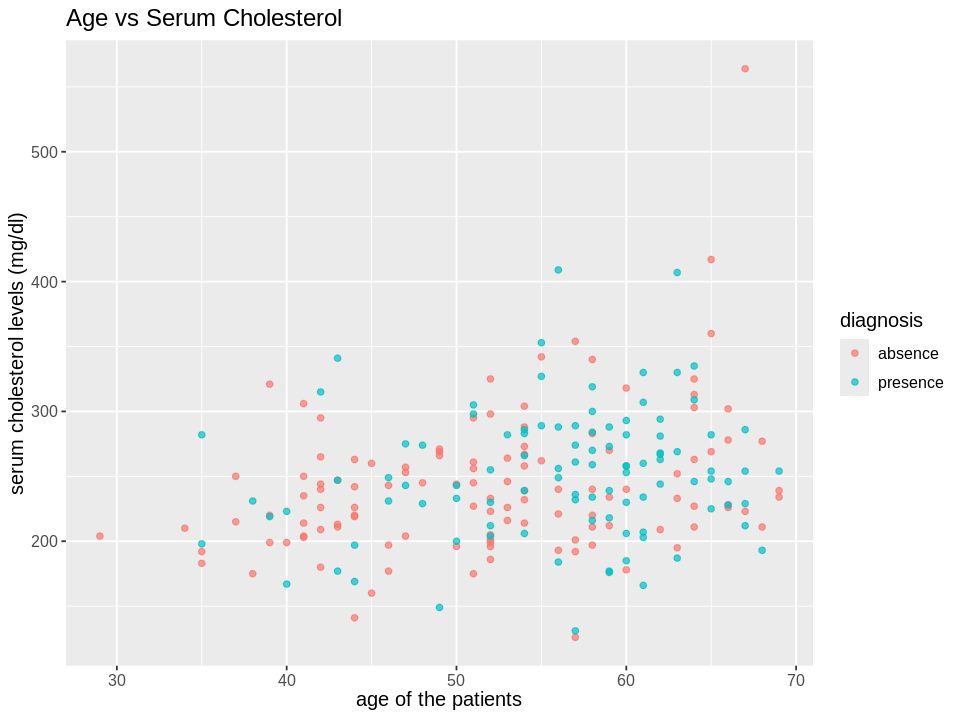

In [9]:
set.seed(2)
options(repr.plot.height = 6, repr.plot.width = 8)

heart_plot <- heart_train |>
    ggplot(aes(x = age, y = cholesterol, colour = diagnosis)) +
    geom_point(alpha = 0.7) +
    labs(x = "age of the patients",
         y = "serum cholesterol levels (mg/dl)",
         colour = "diagnosis") +
    theme(text = element_text(size = 12)) +
    ggtitle("Age vs Serum Cholesterol")
heart_plot

_Figure 6_

The plot shows us how the presence of heart disease increases with increasing age and serum cholesterol levels, verifying the summary of the relationship between the predictors and class (patients with heart disease tend to be older and have higher cholesterol). However, the data is spread out, meaning that the diagnosis is not entirely based on our predictors. 

To find the best $k$ value, 
- I will create a recipe that uses all predictors and a model specification with tuning on the number of neighbours (1 to 50).
- Perform a 5-fold cross-validation on the training set.
- Use workflow and collect the metrics (add model and recipe, and use `tune_grid` instead of `fit`).
- Plot $k$ vs accuracy and find the best $k$.

In [10]:
set.seed(2) 

#Perform Standardization
heart_recipe <- recipe(diagnosis ~ age + cholesterol, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

#Model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode ("classification")

#Perform cross-validation
heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

#Workflow and collect metrics
accuracies <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
head(accuracies)

neighbors .metric  .estimator mean      n std_err    .config              
1  1        accuracy binary     0.5250646 5 0.01831073 Preprocessor1_Model01
2  6        accuracy binary     0.5607024 5 0.04116784 Preprocessor1_Model02
3 11        accuracy binary     0.5883932 5 0.03021286 Preprocessor1_Model03
4 16        accuracy binary     0.5933615 5 0.02618285 Preprocessor1_Model04
5 21        accuracy binary     0.6252948 5 0.03340633 Preprocessor1_Model05
6 26        accuracy binary     0.6207494 5 0.02725117 Preprocessor1_Model06

_Figure 7_

[1] 41

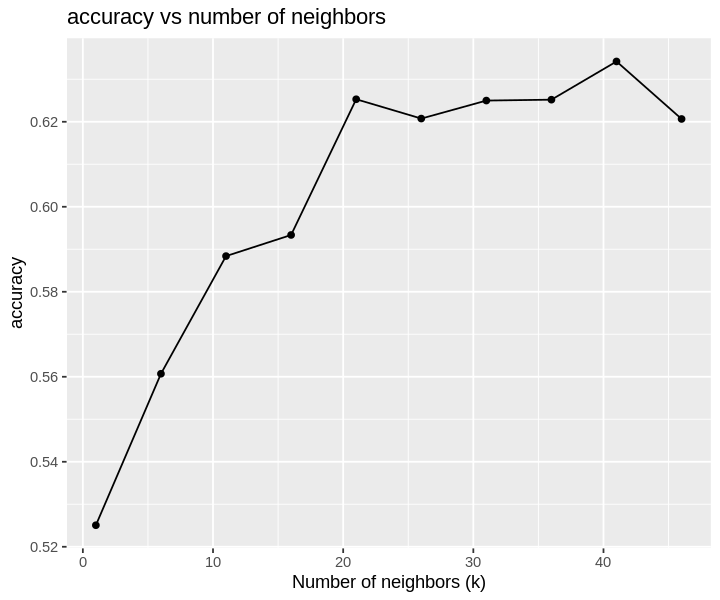

In [11]:
options(repr.plot.height = 5, repr.plot.width = 6)

#Make a line plot
k_value_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
     labs(x = "Number of neighbors (k)", 
          y = "accuracy", 
          title = "accuracy vs number of neighbors")
k_value_plot 

#To find best K
best_k <- accuracies |>
    arrange(-mean) |>
    head(1) |>
    pull(neighbors)
best_k

_Figure 8_

Looking at the line plot above, I will pick $k$ = 41 as the drops to either side aren't drastic and it has a high accuracy. 

With my $k$ value, I will create my final spec and fit into my training set.

In [12]:
set.seed(2) 
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 41) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(heart_spec) |>
       fit(data = heart_train)

Finally, I can use the testing set to see how our classifier performs using `predict`. Also, the accuracy, precision and recall of my classifier need to be looked at.

In [13]:
set.seed(2) 
heart_predictions <- predict(heart_fit, heart_test) |>
    bind_cols(heart_test)

#Use the metrics function
heart_metrics <- heart_predictions |>
        metrics(truth = diagnosis, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate)
heart_metrics

#Confusion matrix
heart_conf_mat <- heart_predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)
heart_conf_mat

.estimate
1 0.6216216

          Truth
Prediction absence presence
  absence       28       16
  presence      12       18

_Figure 9_

The accuracy of my classifier is 62%, labelling 46 out of 74 correctly. 

To find the precision and accuracy, I made 'presence' as the positive label. 

In [14]:
#check the order of the labels
heart_predictions |> pull(diagnosis) |> levels()

[1] "absence"  "presence"

In [15]:
heart_predictions |> 
    precision(truth = diagnosis, estimate = .pred_class, event_level = "second")

.metric   .estimator .estimate
1 precision binary     0.6

_Figure 10_

In [16]:
heart_predictions |>
    recall(truth = diagnosis, estimate = .pred_class, event_level = "second")

.metric .estimator .estimate
1 recall  binary     0.5294118

_Figure 11_

To check for underfitting/overfitting, I will visualize the regions that the model has assigned to each class. 

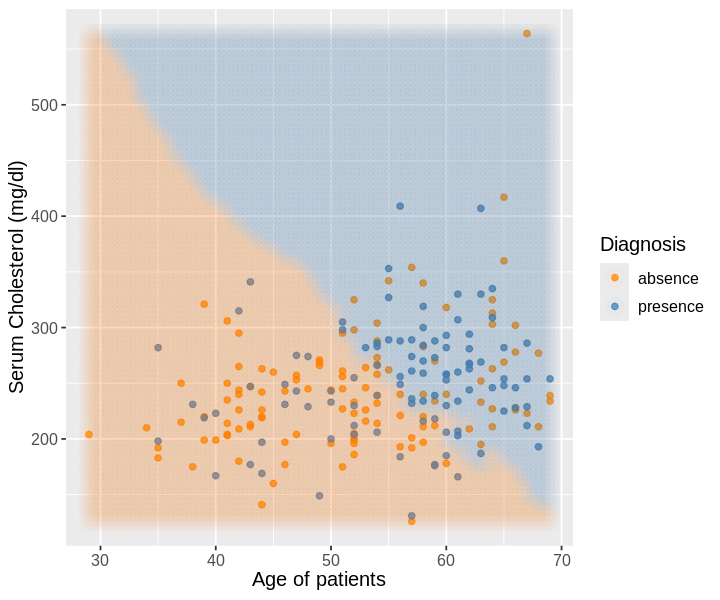

In [17]:

set.seed(2) 
#Create the grid of age/cholesterol vals, and arrange in a data frame
age_grid <- seq(min(heart_filtered_data$age),
                max(heart_filtered_data$age),
                length.out = 100)

chol_grid <- seq(min(heart_filtered_data$cholesterol),
                max(heart_filtered_data$cholesterol),
                length.out = 100)

asgrid <- as_tibble(expand.grid(age = age_grid,
                                cholesterol = chol_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |>
  rename(diagnosis = .pred_class)

# plot with coloured background to check for underfitting/overfitting.
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_train,
             mapping = aes(x = age,
                           y = cholesterol,
                           color = diagnosis),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = age,
                           y = cholesterol,
                           color = diagnosis),
             alpha = 0.02,
             size = 5) +
  labs(color = "Diagnosis",
       x = "Age of patients",
       y = "Serum Cholesterol (mg/dl)") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

wkflw_plot

_Figure 12_

Looking at the plot above, the data themselves are not too underfit or overfit. Hence, I can trust my classifier to predict new data. If it were to be overfit or underfit, our classifier would be unreliable and 
our prediction would be completely different if we were to repeat the process with a different training set. 

**DISCUSSION**:

Summarizing the results: 

To answer my question "Can age and serum cholesterol be used to accurately predict the likelihood of heart disease in a new patient?", I improved my K-nearest neighbour's classifier from the majority classifier with an accuracy of 62%. From the confusion matrix, it is evident that 28 out of 74 diagnoses were done incorrectly. Hence, there is a significant number of misdiagnoses (38% incorrect). In addition, my precision (60%) and recall (53%) were relatively low. In a medical context, high recall is critical to ensure that all potential cases are identified. With low recall, a person with heart disease might be incorrectly diagnosed as not having the condition. Hence, my classifier is not accurate and should not be used in a real-life context. 

However, my visualizations still showed that there was some moderate correlation between the predictors and class (in _Figure 12_). The number of patients with heart disease increased with older age and high serum cholesterol levels. As mentioned in the introduction, increasing serum cholesterol levels and age influence fatty deposits to develop in the blood vessels. Thus, my results support the research findings (how the affected blood flow affects the coronary arteries, eventually leading to heart disease).

Expected Findings: 

I expected the classifier to have a low accuracy because my prediction was only based on a few medical readings. It would be more realistic and meaningful if I had more predictors because heart disease is influenced by factors beyond just age and cholesterol levels. Thus, my classifier might have insufficient data for training.

To improve my classifier, preprocessing the data to balance the classes in my dataset is necessary. From the confusion matrix, my classifier seemed to be biased towards the 'absence' variable when diagnosing, misdiagnosing 16 heart diseased patient as healthy. Thus, before performing the classifier, I could `filter` and `slice` the data to balance the number of classes in the dataset. Furthermore, I can improve tuning my classifier by choosing the appropriate parameters and using a different fold for cross-validation. I could repeat each validation set for values of 1 ≤ $k$ ≤ 100 instead of 1 ≤ $k$ ≤ 50 to get a better range. Using 10-fold instead of 5-fold cross-validation could also reduce the standard error, although further testing is needed to confirm this. 

Impact of the findings and future questions:

Although the findings are not perfect, patients could be informed about the risks. We can enhance preventative care, promoting health programs for individuals with high cholesterol and advancing age. Additionally, this finding could provide a basis for further research, decreasing the potential to diagnose patients with bias for medical practitioners. However, it is recommended to visit a medical professional to confirm the diagnosis. 

Future questions might explore;
- How versatile is our classifier? (eg. can this classifier apply to different demographics?)
- What age is at the most risk for heart disease?
- Which factors other than age and serum cholesterol increase the risk of diagnosis?
- What is the average serum cholesterol level associated with each age group that correlates with an increased risk of heart disease?


**BIBLIOGRAPHY**:

Heart health and aging. (2018, June 1). National Institute on Aging. https://www.nia.nih.gov/health/heart-health/heart-health-and-aging#:~:text=Changes%20that%20happen%20with%20age,of%20arteries%20over%20many%20years.

High cholesterol - Symptoms and causes - Mayo Clinic. (2023, January 11). Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800#:~:text=Your%20body%20needs%20cholesterol%20to,to%20flow%20through%20your%20arteries.

Huizen, J. (2021, September 22). What is serum cholesterol? https://www.medicalnewstoday.com/articles/321519#:~:text=A%20person's%20serum%20cholesterol%20level%20comprises%20the%20amount%20of%20high,conditions%20such%20as%20heart%20disease.

NCI Dictionary of Cancer Terms. (n.d.). Cancer.gov. https://www.cancer.gov/publications/dictionaries/cancer-terms/def/heart-disease

Data:

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.
